# 13 Nucleation Rate

This example will compute the nucleation rate with various precipitate parameters.

Note: the `computeSteadyStateNucleation` function does not account for the number of nucleation sites

### Comparing multiple phases in Al-Mg-Si system

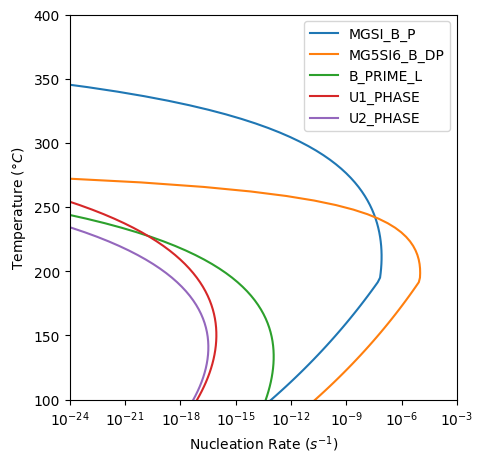

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from kawin.thermo import MulticomponentThermodynamics
from kawin.precipitation.NucleationRate import computeSteadyStateNucleation
from kawin.precipitation.PrecipitationParameters import MatrixParameters, PrecipitateParameters

phases = ['FCC_A1', 'MGSI_B_P', 'MG5SI6_B_DP', 'B_PRIME_L', 'U1_PHASE', 'U2_PHASE']
therm = MulticomponentThermodynamics('AlMgSi.tdb', ['AL', 'MG', 'SI'], phases)

matrix = MatrixParameters(['MG', 'SI'])
matrix.volume.setVolume(1e-5, 'VM', 4)

gamma = {
    'MGSI_B_P': 0.18,
    'MG5SI6_B_DP': 0.084,
    'B_PRIME_L': 0.18,
    'U1_PHASE': 0.18,
    'U2_PHASE': 0.18
        }

precipitates = []
for p in phases[1:]:
    params = PrecipitateParameters(p)
    params.gamma = gamma[p]
    params.volume.setVolume(1e-5, 'VM', 4)
    precipitates.append(params)

fig, ax = plt.subplots(figsize=(5,5))
T = np.linspace(50, 400, 100) + 273.15
for prec in precipitates:
    nucRate = computeSteadyStateNucleation(therm, [0.0072, 0.0057], T, prec, matrix)
    ax.plot(nucRate.nucleation_rate, T-273.15, label=prec.name)
ax.set_ylim([100, 400])
ax.set_xlim([1e-24, 1e-3])
ax.set_xscale('log')
ax.set_xlabel(r'Nucleation Rate ($s^{-1}$)')
ax.set_ylabel(r'Temperature ($\degree C $)')
ax.legend()
plt.show()

### Comparing nucleation on different nucleation sites for Al-Zr

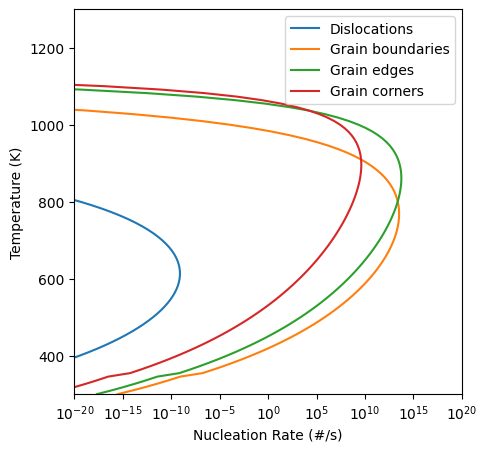

In [2]:
from kawin.thermo import BinaryThermodynamics

therm = BinaryThermodynamics('AlScZr.tdb', elements=['AL', 'ZR'], phases=['FCC_A1', 'AL3ZR'])
therm.setGuessComposition(0.24)

D0 = 0.0768         #Diffusivity pre-factor (m2/s)
Q = 242000          #Activation energy (J/mol)
diff = lambda T: D0 * np.exp(-Q / (8.314 * T))
therm.setDiffusivity(diff, 'FCC_A1')

a = 0.405e-9      # nm
Va = a**3         # nm^3
atomsPerCell = 4

matrix = MatrixParameters(solutes=['ZR'])
matrix.volume.setVolume(Va, 'VA', atomsPerCell)
matrix.GBenergy = 0.3
matrix.nucleationSites.setDislocationDensity(1e15)
matrix.nucleationSites.setGrainSize(100)

precipitate = PrecipitateParameters('AL3ZR')
precipitate.gamma = 0.25   # J/m2
precipitate.volume.setVolume(Va, 'VA', atomsPerCell)
precipitate.nucleation.gbEnergy = matrix.GBenergy

nucleationSites = ['dislocations', 'grain boundaries', 'grain edges', 'grain corners']
N0 = {
    'dislocations': matrix.nucleationSites.dislocationN0,
    'grain boundaries': matrix.nucleationSites.GBareaN0,
    'grain edges': matrix.nucleationSites.GBedgeN0,
    'grain corners': matrix.nucleationSites.GBcornerN0
}

fig, ax = plt.subplots(figsize=(5,5))
T = np.linspace(300, 1200, 100)
for site in nucleationSites:
    precipitate.nucleation.setNucleationType(site)
    nucRate = computeSteadyStateNucleation(therm, 4e-3, T, precipitate, matrix)
    ax.plot(N0[site]*nucRate.nucleation_rate, T, label=site.capitalize())
ax.legend()
ax.set_xlim([1e-20, 1e20])
ax.set_xscale('log')
ax.set_ylim([300, 1300])
ax.set_xlabel('Nucleation Rate (#/s)')
ax.set_ylabel('Temperature (K)')
plt.show()